# Transfer learning with VGG

This notebook uses the Fruits-360 dataset from Kaggle, provided by: Horea Muresan, [Mihai Oltean]
(https://mihaioltean.github.io), [Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning), Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.

Code is applied based on Udemy's Lazyprogrammer's Advanced Computer Vision course.

### 1. Loading the data

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

from keras import Input, Model
from keras.layers import Flatten, Dense, Lambda, Activation
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from glob import glob


In [2]:
!pwd

/content


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip -qq 'gdrive/MyDrive/large_files/archive.zip' # Use -qq option to suppress the output

In [5]:
!ls

fruits-360  gdrive  sample_data


In [6]:
!pwd

/content


## 2. Define limited dataset for testing

In [ ]:
# make limited datasets for testing purposes
def mkdir(p):
  if not os.path.exists(p):
    os.mkdir(p)

def link(src,dst):
  if not os.path.exists(dst):
    os.symlink(src,dst,target_is_directory=True)

mkdir('fruits-360-small')

classes = [
  'Apple Golden 1',
  'Avocado',
  'Lemon',
  'Mango',
  'Kiwi',
  'Banana',
  'Strawberry',
  'Raspberry'
]

train_path_from = os.path.abspath('./fruits-360/Training')
valid_path_from = os.path.abspath('./fruits-360/Test')

train_path_to = os.path.abspath('./fruits-360-small/Training')
valid_path_to = os.path.abspath('./fruits-360-small/Test')

mkdir(train_path_to)
mkdir(valid_path_to)

for c in classes:
  link(train_path_from + '/' + c, train_path_to + '/' + c)
  link(valid_path_from + '/' + c, valid_path_to + '/' + c)

## 3. Variables and constants for the code

In [7]:
IMAGE_SIZE=(100,100)
epochs=5
batch_size=32

In [8]:
# train_path = './fruits-360-small/Training'
# test_path = './fruits-360-small/Test'

train_path = './fruits-360/Training'
test_path = './fruits-360/Test'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

In [9]:
image_files[0:2]

['./fruits-360/Training/Papaya/r_294_100.jpg',
 './fruits-360/Training/Papaya/r_20_100.jpg']

In [10]:
test_image_files[0:2]

['./fruits-360/Test/Papaya/7_100.jpg', './fruits-360/Test/Papaya/r_6_100.jpg']

## 4. Creating the data generators

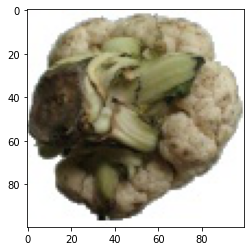

In [13]:
# Let's look at a random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [14]:
# Create image datagenerator, that augments images and preprocesses them
img_gen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input # Note, preprocessing specific to vgg16
)

In [ ]:
# Create batch generator with the help of image datagenerator instance
# This utilizes the particular folder structure available here

# To test it first, we name it draft_generator
draft_generator=img_gen.flow_from_directory(test_path,
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=batch_size)

Found 496 images belonging to 3 classes.


In [ ]:
# Check the class indices
print(draft_generator.class_indices)
labels=[None]*len(draft_generator.class_indices)
for k,v in draft_generator.class_indices.items():
  labels[v]=k
labels

{'Banana': 0, 'Raspberry': 1, 'Strawberry': 2}


['Banana', 'Raspberry', 'Strawberry']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of x: (100, 100, 3), shape of y: (3,)
min: -104.77742767333984, ,max: 151.06100463867188


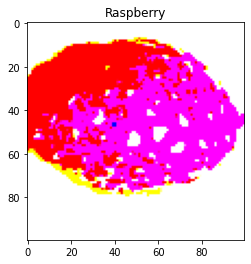

In [ ]:
# Let's check that the generator works properly
# Note, the colors look weird, since VGG uses ordering BGR instead of RGB
for x,y in draft_generator:
  print(f"shape of x: {x[0].shape}, shape of y: {y[0].shape}")
  print(f"min: {x[0].min()}, ,max: {x[0].max()}")
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [15]:
# Let's create the generators for training and test sets:
train_generator=img_gen.flow_from_directory(train_path,
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=batch_size)
test_generator=img_gen.flow_from_directory(test_path,
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=batch_size)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## 5. Build the model

In [16]:
# We use pretrained weights from VGG16, and train our own classification dense layer at the top

# Create an instance of VGG16
vgg=VGG16(include_top=False,weights='imagenet',input_shape=IMAGE_SIZE+(3,))

# Define that we don't train the layers of vgg
for layer in vgg.layers:
  layer.trainable=False

# Define our own classification layer
x=Flatten()(vgg.output)
x=Dense(len(folders))(x)        # Number of classes as output
outputs=Activation('softmax')(x)

# Create the model
model=Model(inputs=vgg.input,outputs=outputs)
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_______________________________________________________

In [17]:
# Compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

## 6. Train the model

#### a) Model with 3 classes

Let's first train the model with only three classes: 'Banana', 'Raspberry', 'Strawberry'.

In [ ]:
r=model.fit(train_generator,
            validation_data=test_generator,
            epochs=epochs,
            steps_per_epoch=len(image_files)//batch_size,
            validation_steps=len(test_image_files)//batch_size
            )

Epoch 1/5
46/46 [==============================] - 197s 4s/step - loss: 0.5323 - accuracy: 0.9708 - val_loss: 0.0160 - val_accuracy: 0.9937
Epoch 2/5
46/46 [==============================] - 196s 4s/step - loss: 0.0030 - accuracy: 0.9986 - val_loss: 0.0893 - val_accuracy: 0.9833
Epoch 3/5
46/46 [==============================] - 198s 4s/step - loss: 5.8146e-05 - accuracy: 1.0000 - val_loss: 3.6803e-07 - val_accuracy: 1.0000
Epoch 4/5
46/46 [==============================] - 195s 4s/step - loss: 3.2394e-10 - accuracy: 1.0000 - val_loss: 2.0117e-08 - val_accuracy: 1.0000
Epoch 5/5
46/46 [==============================] - 198s 4s/step - loss: 0.0126 - accuracy: 0.9973 - val_loss: 0.0352 - val_accuracy: 0.9979


#### b) Model with 8 classes

Next, train the model with eight classes:  'Apple Golden 1', 'Avocado', 'Lemon', 'Mango', 'Kiwi', 'Banana', 'Strawberry', 'Raspberry'.


In [ ]:
r8=model.fit(train_generator,
            validation_data=test_generator,
            epochs=epochs,
            steps_per_epoch=len(image_files)//batch_size,
            validation_steps=len(test_image_files)//batch_size
            )

Epoch 1/5
119/119 [==============================] - 527s 4s/step - loss: 0.6580 - accuracy: 0.9457 - val_loss: 0.1480 - val_accuracy: 0.9773
Epoch 2/5
119/119 [==============================] - 532s 4s/step - loss: 0.0744 - accuracy: 0.9916 - val_loss: 0.0213 - val_accuracy: 0.9969
Epoch 3/5
119/119 [==============================] - 522s 4s/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 8.0206e-04 - val_accuracy: 0.9992
Epoch 4/5
119/119 [==============================] - 524s 4s/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 0.0224 - val_accuracy: 0.9961
Epoch 5/5
119/119 [==============================] - 523s 4s/step - loss: 0.0154 - accuracy: 0.9979 - val_loss: 0.0241 - val_accuracy: 0.9961


#### c) Model with 131 classes (whole dataset)

In [18]:
r131=model.fit(train_generator,
            validation_data=test_generator,
            epochs=epochs,
            steps_per_epoch=len(image_files)//batch_size,
            validation_steps=len(test_image_files)//batch_size
            )

Epoch 1/5
2115/2115 [==============================] - 290s 137ms/step - loss: 1.6195 - accuracy: 0.8837 - val_loss: 1.5079 - val_accuracy: 0.9113
Epoch 2/5
2115/2115 [==============================] - 289s 137ms/step - loss: 0.3112 - accuracy: 0.9729 - val_loss: 1.3834 - val_accuracy: 0.9333
Epoch 3/5
2115/2115 [==============================] - 289s 137ms/step - loss: 0.2178 - accuracy: 0.9821 - val_loss: 1.2698 - val_accuracy: 0.9371
Epoch 4/5
2115/2115 [==============================] - 290s 137ms/step - loss: 0.1631 - accuracy: 0.9868 - val_loss: 1.1926 - val_accuracy: 0.9458
Epoch 5/5
2115/2115 [==============================] - 289s 137ms/step - loss: 0.1367 - accuracy: 0.9895 - val_loss: 1.3686 - val_accuracy: 0.9423


###7. Evaluate the model

In [19]:
# To enable to create confusion matrix, we need to have the array of targets and predictions
# These are created here with the help of the data generator
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in img_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, 
                                          shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [20]:
# This function plots a nicer looking confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


#### a) Model with 3 classes

In [ ]:
score=model.evaluate(test_generator)

16/16 [==============================] - 50s 3s/step - loss: 8.9018e-04 - accuracy: 1.0000


In [ ]:
print(f"loss:{score[0]}, accuracy:{score[1]}")

loss:0.0008901791297830641, accuracy:1.0


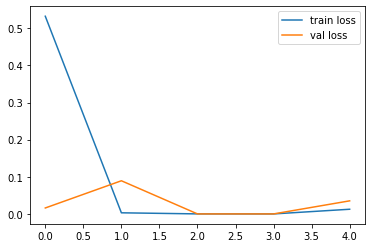

In [ ]:
# Plot losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

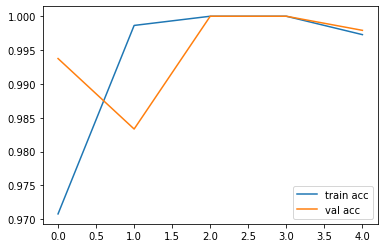

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
# Print out the confusion matrix using scikit-learn method
cm = get_confusion_matrix(train_path, len(image_files))
print("Confusion matrix for training set:", '\n',cm)
test_cm = get_confusion_matrix(test_path, len(test_image_files))
print("Confusion matrix for test set:",'\n',test_cm)

Generating confusion matrix 1472
Found 1472 images belonging to 3 classes.
Confusion matrix for training set: 
 [[490   0   0]
 [  0 490   0]
 [  0   0 492]]
Generating confusion matrix 496
Found 496 images belonging to 3 classes.
Confusion matrix for test set: 
 [[164   0   2]
 [  0 166   0]
 [  0   0 164]]


Confusion matrix, without normalization


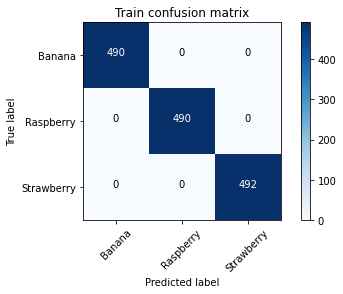

Confusion matrix, without normalization


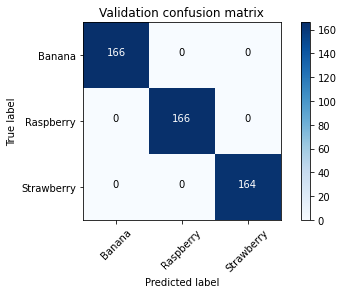

In [ ]:
#Print confusion matrix with labels
labels=[None]*len(test_generator.class_indices)
for k,v in test_generator.class_indices.items():
  labels[v]=k
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(test_cm, labels, title='Validation confusion matrix')

#### b) Model with 8 classes

In [ ]:
score8=model.evaluate(test_generator)

41/41 [==============================] - 129s 3s/step - loss: 0.0115 - accuracy: 0.9977


In [ ]:
print(f"loss:{score8[0]}, accuracy:{score8[1]}")

loss:0.011522614397108555, accuracy:0.9976653456687927


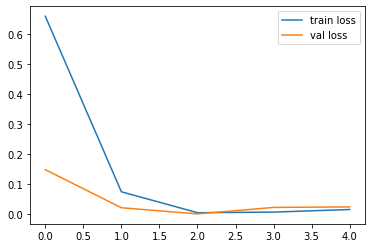

In [ ]:
# Plot losses
plt.plot(r8.history['loss'], label='train loss')
plt.plot(r8.history['val_loss'], label='val loss')
plt.legend()
plt.show()

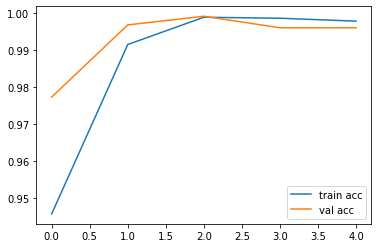

In [ ]:
# accuracies
plt.plot(r8.history['accuracy'], label='train acc')
plt.plot(r8.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
# Print out the confusion matrix using scikit-learn method
cm = get_confusion_matrix(train_path, len(image_files))
print("Confusion matrix for training set:", '\n',cm)
test_cm = get_confusion_matrix(test_path, len(test_image_files))
print("Confusion matrix for test set:",'\n',test_cm)

Generating confusion matrix 3827
Found 3827 images belonging to 8 classes.
50
Confusion matrix for training set: 
 [[480   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1285
Found 1285 images belonging to 8 classes.
Confusion matrix for test set: 
 [[159   0   0   0   1   0   0   0]
 [  0 141   0   1   0   1   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


Confusion matrix, without normalization


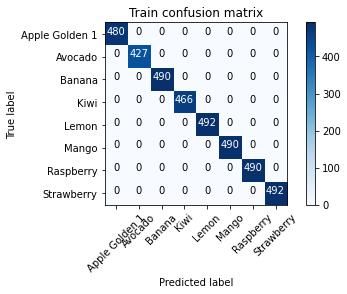

Confusion matrix, without normalization


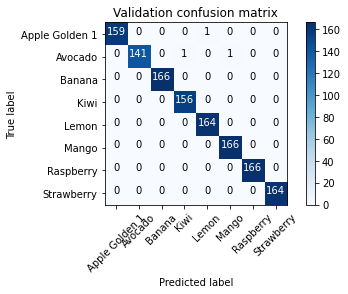

In [ ]:
#Print confusion matrix with labels
labels=[None]*len(test_generator.class_indices)
for k,v in test_generator.class_indices.items():
  labels[v]=k
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(test_cm, labels, title='Validation confusion matrix')

#### c) Model with the whole dataset: 131 classes

In [21]:
score131=model.evaluate(test_generator)

709/709 [==============================] - 73s 103ms/step - loss: 1.3632 - accuracy: 0.9439


In [ ]:
print(f"loss:{score131[0]}, accuracy:{score8[1]}")

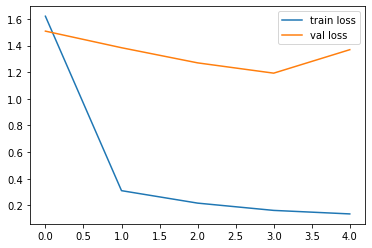

In [22]:
# Plot losses
plt.plot(r131.history['loss'], label='train loss')
plt.plot(r131.history['val_loss'], label='val loss')
plt.legend()
plt.show()

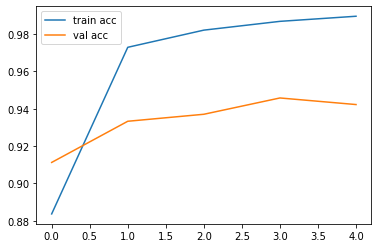

In [23]:
# Plot accuracies
plt.plot(r131.history['accuracy'], label='train acc')
plt.plot(r131.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()